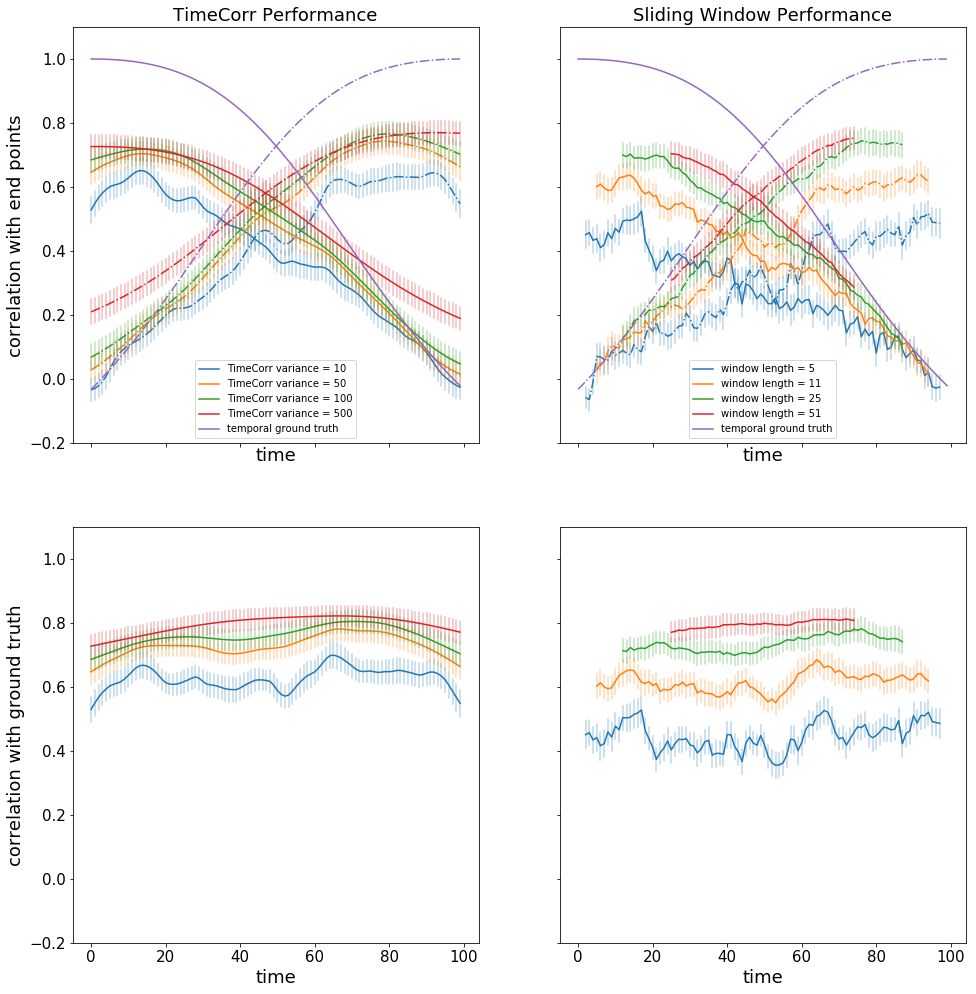

In [5]:
######## timecorr vs sliding window, different variances & ramp correlation
import sys
import os
sys.path.append(os.path.abspath('../timecorr/'))
from _shared.helpers import wcorr, sliding_window
import matplotlib.pyplot as plt
import matplotlib
from math import log
import numpy as np
from scipy.linalg import cholesky
from scipy.spatial.distance import squareform
from scipy.stats.stats import pearsonr
from math import sqrt
variance = [10,50,100,500]
sliding_window_length = [5,11,25,51]
repetitions=100
var_num = len(variance)
slide_num = len(sliding_window_length)

block_length = 1
covariance_num =  100
time_len = int(block_length * covariance_num)
activation_num = 5
activations = np.random.normal(0,10,[activation_num, time_len])
correlations = np.zeros([covariance_num,activation_num,activation_num])
correlation1,correlation2 = np.zeros([activation_num,activation_num]), np.zeros([activation_num,activation_num])

def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

def cholesky_ramp_correlation_data():
    global activations, correlations,correlation1,correlation2
    correlations = np.zeros([covariance_num,activation_num,activation_num])
    activations = np.random.normal(0,10,[activation_num, time_len])
    correlation1,correlation2 = np.zeros([activation_num,activation_num]), np.zeros([activation_num,activation_num])
    
    while not is_pos_def(correlation1):
        feature_map = np.random.normal(0,1,[activation_num,activation_num])
        correlation1 = 2*np.dot(feature_map,feature_map.T)-1
        correlation1 = correlation1/np.max(abs(correlation1))
        
    while not is_pos_def(correlation2):
        feature_map1 = np.random.normal(0,1,[activation_num,activation_num])
        correlation2 = 2*np.dot(feature_map1,feature_map1.T)-1
        correlation2 = correlation2/np.max(abs(correlation2))
        
    for i in range(time_len):
        cov_temp = (time_len-i)*0.5*(np.log(1+correlation1+1e-5) - np.log(1-correlation1+1e-5))/float(time_len)+i*0.5*(np.log(1+correlation2+1e-5) - np.log(1-correlation2+1e-5))/float(time_len)
        correlations[i] =  (np.exp(2*cov_temp) - 1)/(np.exp(2*cov_temp) + 1)
        activations[:,i] = np.dot(cholesky(correlations[i]),activations[:,i])
#     correlations[0]=correlation1
#     correlations[1]=correlation2
#     activations[:,:block_length]=np.dot(cholesky(correlation1),activations[:,:block_length])
#     activations[:,block_length:]=np.dot(cholesky(correlation2),activations[:,block_length:])




timecorr_correlations1,timecorr_correlations2 = np.zeros([repetitions,var_num,time_len]),np.zeros([repetitions,var_num,time_len])
sliding_window_correlations1,sliding_window_correlations2 = np.zeros([repetitions,slide_num,time_len]),np.zeros([repetitions,slide_num,time_len])
true_correlations1,true_correlations2 = np.zeros([time_len]),np.zeros([time_len])

timecorr_correlations_single = np.zeros([repetitions,var_num,time_len])
sliding_window_correlations_single = np.zeros([repetitions,slide_num,time_len])

color = ['b','r','k']

#timecorr_recovery = np.zeros([var_num,time_len,(activation_num * (activation_num-1) / 2)])
#sliding_window_recovery = np.zeros([slide_num, time_len,(activation_num * (activation_num-1) / 2)])
#true_recovery = np.zeros([time_len,(activation_num * (activation_num-1) / 2)])

timecorr_recovery = np.zeros([var_num,time_len,int((activation_num * (activation_num-1) / 2))])
sliding_window_recovery = np.zeros([slide_num, time_len,int((activation_num * (activation_num-1) / 2))])
true_recovery = np.zeros([time_len,int((activation_num * (activation_num-1) / 2))])

for i in range(repetitions):
    cholesky_ramp_correlation_data()
    for v in range(var_num):
        timecorr_recovery[v] = wcorr(activations,variance[v])
        sliding_window_recovery[v,int(sliding_window_length[v]/2):(time_len-int(sliding_window_length[v]/2))] = sliding_window(activations,sliding_window_length[v]) 
        
    for t in range(time_len):
        true_recovery[t] = squareform(correlations[int(t/block_length)],checks=False)
    for timepoint in range(time_len):
        for v in range(var_num):
            otc1 = pearsonr(timecorr_recovery[v,timepoint], squareform(correlation1,checks=False))[0]
            timecorr_correlations1[i,v,timepoint] += 0.5 * (log(1+otc1) - log(1-otc1))
            otc2 = pearsonr(timecorr_recovery[v,timepoint], squareform(correlation2,checks=False))[0]
            timecorr_correlations2[i,v,timepoint] += 0.5 * (log(1+otc2) - log(1-otc2))
            
            otcs = pearsonr(timecorr_recovery[v, timepoint], true_recovery[timepoint])[0]
#             otcs = pearsonr(timecorr_recovery[v, timepoint], squareform(correlations[timepoint/block_length],checks=False))[0]
            timecorr_correlations_single[i,v, timepoint]+= 0.5 * (log(1+otcs) - log(1-otcs))
        
            if timepoint>int(sliding_window_length[v]/2)-1 and timepoint<time_len-int(sliding_window_length[v]/2):
                sc1 = pearsonr(sliding_window_recovery[v,timepoint], squareform(correlation1,checks=False))[0]
                sliding_window_correlations1[i,v,timepoint] += 0.5 * (log(1+sc1) - log(1-sc1))
                sc2 = pearsonr(sliding_window_recovery[v,timepoint], squareform(correlation2,checks=False))[0]
                sliding_window_correlations2[i,v,timepoint] += 0.5 * (log(1+sc2) - log(1-sc2))
                swc = pearsonr(sliding_window_recovery[v,timepoint], true_recovery[timepoint])[0]
#                 swc = pearsonr(sliding_window_recovery[v,timepoint], squareform(correlations[timepoint/block_length],checks=False))[0]
                sliding_window_correlations_single[i,v,timepoint] += 0.5 * (log(1+swc) - log(1-swc))

    
        tc1 = pearsonr(true_recovery[timepoint], squareform(correlation1,checks=False))[0]
        true_correlations1[timepoint] += 0.5 * (log(1+tc1) - log(1-tc1+1e-5))
        tc2 = pearsonr(true_recovery[timepoint], squareform(correlation2,checks=False))[0]
        true_correlations2[timepoint] += 0.5 * (log(1+tc2) - log(1-tc2+1e-5))
           
timecorr_correlations1_std = np.std(timecorr_correlations1,0)/sqrt(repetitions)
timecorr_correlations1_std =  (np.exp(2*timecorr_correlations1_std) - 1)/(np.exp(2*timecorr_correlations1_std) + 1)
timecorr_correlations1 = np.mean(timecorr_correlations1,0)
# timecorr_correlations1 /= repetitions
timecorr_correlations1 =  (np.exp(2*timecorr_correlations1) - 1)/(np.exp(2*timecorr_correlations1) + 1)

timecorr_correlations2_std = np.std(timecorr_correlations2,0)/sqrt(repetitions)
timecorr_correlations2_std =  (np.exp(2*timecorr_correlations2_std) - 1)/(np.exp(2*timecorr_correlations2_std) + 1)
timecorr_correlations2 = np.mean(timecorr_correlations2,0)
# timecorr_correlations2 /= repetitions
timecorr_correlations2 =  (np.exp(2*timecorr_correlations2) - 1)/(np.exp(2*timecorr_correlations2) + 1)

sliding_window_correlations1_std = np.std(sliding_window_correlations1,0)/sqrt(repetitions)
sliding_window_correlations1_std =  (np.exp(2*sliding_window_correlations1_std) - 1)/(np.exp(2*sliding_window_correlations1_std) + 1)
sliding_window_correlations1 = np.mean(sliding_window_correlations1,0)
sliding_window_correlations1 =  (np.exp(2*sliding_window_correlations1) - 1)/(np.exp(2*sliding_window_correlations1) + 1)

sliding_window_correlations2_std = np.std(sliding_window_correlations2,0)/sqrt(repetitions)
sliding_window_correlations2_std =  (np.exp(2*sliding_window_correlations2_std) - 1)/(np.exp(2*sliding_window_correlations2_std) + 1)
sliding_window_correlations2 = np.mean(sliding_window_correlations2,0)
sliding_window_correlations2 =  (np.exp(2*sliding_window_correlations2) - 1)/(np.exp(2*sliding_window_correlations2) + 1)

true_correlations1 /= repetitions
true_correlations1 =  (np.exp(2*true_correlations1) - 1)/(np.exp(2*true_correlations1) + 1)

true_correlations2 /= repetitions
true_correlations2 =  (np.exp(2*true_correlations2) - 1)/(np.exp(2*true_correlations2) + 1)

timecorr_correlations_single_std = np.std(timecorr_correlations_single,0)/sqrt(repetitions)
timecorr_correlations_single_std =  (np.exp(2*timecorr_correlations_single_std) - 1)/(np.exp(2*timecorr_correlations_single_std) + 1)
timecorr_correlations_single = np.mean(timecorr_correlations_single,0)
# timecorr_correlations_single /= repetitions
timecorr_correlations_single = (np.exp(2*timecorr_correlations_single) - 1)/(np.exp(2*timecorr_correlations_single) + 1) 

sliding_window_correlations_single_std = np.std(sliding_window_correlations_single,0)/sqrt(repetitions)
sliding_window_correlations_single_std =  (np.exp(2*sliding_window_correlations_single_std) - 1)/(np.exp(2*sliding_window_correlations_single_std) + 1)
sliding_window_correlations_single = np.mean(sliding_window_correlations_single,0)
sliding_window_correlations_single =(np.exp(2*sliding_window_correlations_single) - 1)/(np.exp(2*sliding_window_correlations_single) + 1) 


f, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, sharey='row', sharex='col', figsize=(16,16))
a1,a2= [ax1,ax2],[ax3,ax4]
plt.subplots_adjust(top=0.92)

# plt.suptitle("temporal ground truth linearly transforming from component A to component B over 500 timepoints",fontsize=20)
ax1.set_title("TimeCorr Performance",fontsize=18)
ax2.set_title("Sliding Window Performance",fontsize=18)
# a1[2].set_title("variance = 1000, sliding window = 25",fontsize=18)
# a1[3].set_title("variance = 1500, sliding window = 25",fontsize=18)
ax1.set_ylabel("correlation with end points",fontsize=18)
ax3.set_ylabel("correlation with ground truth",fontsize=18)
for v in range(var_num): 
    lower_limit, upper_limit = int(sliding_window_length[v]/2),(time_len-int(sliding_window_length[v]/2))
    ax1.plot(range(time_len),timecorr_correlations1[v],c='C'+str(v),linestyle='-',alpha=1.0, label = "TimeCorr variance = "+str(variance[v]))
    ax1.plot(range(time_len),timecorr_correlations2[v],c='C'+str(v),linestyle='-.',alpha=1.0)

    ax2.plot(range(lower_limit,upper_limit),sliding_window_correlations1[v,lower_limit:upper_limit],c='C'+str(v),linestyle='-',alpha=1,label = "window length = "+str(sliding_window_length[v]))
    ax2.plot(range(lower_limit,upper_limit),sliding_window_correlations2[v,lower_limit:upper_limit],c='C'+str(v),linestyle='-.',alpha=1)
    

    ax1.plot([range(time_len) for i in range(2)],[timecorr_correlations1[v]+timecorr_correlations1_std[v],timecorr_correlations1[v]-timecorr_correlations1_std[v]],c='C'+str(v),linestyle='-',alpha=0.3)
    ax1.plot([range(time_len) for i in range(2)],[timecorr_correlations2[v]+timecorr_correlations2_std[v],timecorr_correlations2[v]-timecorr_correlations2_std[v]],c='C'+str(v),linestyle='-',alpha=0.3)
    ax2.plot([range(lower_limit,upper_limit) for i in range(2)],[sliding_window_correlations1[v,lower_limit:upper_limit]+sliding_window_correlations1_std[v,lower_limit:upper_limit],sliding_window_correlations1[v,lower_limit:upper_limit]-sliding_window_correlations1_std[v,lower_limit:upper_limit]],c='C'+str(v),linestyle='-',alpha=0.3)
    ax2.plot([range(lower_limit,upper_limit) for i in range(2)],[sliding_window_correlations2[v,lower_limit:upper_limit]+sliding_window_correlations2_std[v,lower_limit:upper_limit],sliding_window_correlations2[v,lower_limit:upper_limit]-sliding_window_correlations2_std[v,lower_limit:upper_limit]],c='C'+str(v),linestyle='-',alpha=0.3)

    ax3.plot(range(time_len),timecorr_correlations_single[v],c='C'+str(v),alpha=1,linestyle='-')
    ax3.plot([range(time_len) for i in range(2)],[timecorr_correlations_single[v]+timecorr_correlations_single_std[v],timecorr_correlations_single[v]-timecorr_correlations_single_std[v]],c='C'+str(v),linestyle='-',alpha=0.3)
    ax4.plot([range(lower_limit,upper_limit) for i in range(2)],[sliding_window_correlations_single[v,lower_limit:upper_limit]+sliding_window_correlations_single_std[v,lower_limit:upper_limit],sliding_window_correlations_single[v,lower_limit:upper_limit]-sliding_window_correlations_single_std[v,lower_limit:upper_limit]],c='C'+str(v),linestyle='-',alpha=0.3)
    ax4.plot(range(lower_limit,upper_limit),sliding_window_correlations_single[v,lower_limit:upper_limit],c='C'+str(v),alpha=1,linestyle='-')
    ax3.set_xlabel("time",fontsize=18)
    ax3.tick_params(labelsize=15)
    ax4.set_xlabel("time",fontsize=18)
    ax4.tick_params(labelsize=15)
#     a2[v].tick_params(labelsize=15)

ax1.plot(range(time_len),true_correlations1,c='C'+str(v+1),linestyle='-',alpha=1,label = "temporal ground truth")
ax1.plot(range(time_len),true_correlations2,c='C'+str(v+1),linestyle='-.',alpha=1)
ax2.plot(range(time_len),true_correlations1,c='C'+str(v+1),linestyle='-',alpha=1,label = "temporal ground truth")
ax2.plot(range(time_len),true_correlations2,c='C'+str(v+1),linestyle='-.',alpha=1)

#     a2[v].set_xlabel("time",fontsize=18)
#     a2[v].tick_params(labelsize=15)
#     if v==var_num-1:

ax1.legend(loc='lower center')
ax1.set_ylim(-0.2, 1.1)
ax1.set_xlabel("time",fontsize=18)
ax1.tick_params(labelsize=15)

ax2.legend(loc='lower center')
ax2.set_ylim(-0.2, 1.1)
ax2.set_xlabel("time",fontsize=18)
ax2.tick_params(labelsize=15)

# ax3.legend(loc='lower center')
ax3.set_ylim(-0.2, 1.1)
ax3.set_xlabel("time",fontsize=18)
ax3.tick_params(labelsize=15)

# ax4.legend(loc='lower center')
ax4.set_ylim(-0.2, 1.1)
ax4.set_xlabel("time",fontsize=18)
ax4.tick_params(labelsize=15)
        
plt.show()


In [ ]:
f, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, sharey='row', sharex='col', figsize=(16,16))
a1,a2= [ax1,ax2],[ax3,ax4]
plt.subplots_adjust(top=0.92)

# plt.suptitle("temporal ground truth linearly transforming from component A to component B over 500 timepoints",fontsize=20)
ax1.set_title("TimeCorr Performance",fontsize=18)
ax2.set_title("Sliding Window Performance",fontsize=18)
# a1[2].set_title("variance = 1000, sliding window = 25",fontsize=18)
# a1[3].set_title("variance = 1500, sliding window = 25",fontsize=18)
ax1.set_ylabel("correlation with end points",fontsize=18)
ax3.set_ylabel("correlation with ground truth",fontsize=18)
for v in range(var_num): 
    lower_limit, upper_limit = int(sliding_window_length[v]/2),(time_len-int(sliding_window_length[v]/2))
    ax1.plot(range(time_len),timecorr_correlations1[v],c='C'+str(v),linestyle='-',alpha=1.0, label = "TimeCorr variance = "+str(variance[v]))
    ax1.plot(range(time_len),timecorr_correlations2[v],c='C'+str(v),linestyle='-.',alpha=1.0)

    ax2.plot(range(lower_limit,upper_limit),sliding_window_correlations1[v,lower_limit:upper_limit],c='C'+str(v),linestyle='-',alpha=1,label = "window length = "+str(sliding_window_length[v]))
    ax2.plot(range(lower_limit,upper_limit),sliding_window_correlations2[v,lower_limit:upper_limit],c='C'+str(v),linestyle='-.',alpha=1)
    

    ax1.plot([range(time_len) for i in range(2)],[timecorr_correlations1[v]+timecorr_correlations1_std[v],timecorr_correlations1[v]-timecorr_correlations1_std[v]],c='C'+str(v),linestyle='-',alpha=0.05)
    ax1.plot([range(time_len) for i in range(2)],[timecorr_correlations2[v]+timecorr_correlations2_std[v],timecorr_correlations2[v]-timecorr_correlations2_std[v]],c='C'+str(v),linestyle='-',alpha=0.05)
    ax2.plot([range(lower_limit,upper_limit) for i in range(2)],[sliding_window_correlations1[v,lower_limit:upper_limit]+sliding_window_correlations1_std[v,lower_limit:upper_limit],sliding_window_correlations1[v,lower_limit:upper_limit]-sliding_window_correlations1_std[v,lower_limit:upper_limit]],c='C'+str(v),linestyle='-',alpha=0.1)
    ax2.plot([range(lower_limit,upper_limit) for i in range(2)],[sliding_window_correlations2[v,lower_limit:upper_limit]+sliding_window_correlations2_std[v,lower_limit:upper_limit],sliding_window_correlations2[v,lower_limit:upper_limit]-sliding_window_correlations2_std[v,lower_limit:upper_limit]],c='C'+str(v),linestyle='-',alpha=0.1)

    ax3.plot(range(time_len),timecorr_correlations_single[v],c='C'+str(v),alpha=1,linestyle='-')
    ax3.plot([range(time_len) for i in range(2)],[timecorr_correlations_single[v]+timecorr_correlations_single_std[v],timecorr_correlations_single[v]-timecorr_correlations_single_std[v]],c='C'+str(v),linestyle='-',alpha=0.3)
    ax4.plot([range(lower_limit,upper_limit) for i in range(2)],[sliding_window_correlations_single[v,lower_limit:upper_limit]+sliding_window_correlations_single_std[v,lower_limit:upper_limit],sliding_window_correlations_single[v,lower_limit:upper_limit]-sliding_window_correlations_single_std[v,lower_limit:upper_limit]],c='C'+str(v),linestyle='-',alpha=0.3)
    ax4.plot(range(lower_limit,upper_limit),sliding_window_correlations_single[v,lower_limit:upper_limit],c='C'+str(v),alpha=1,linestyle='-')
    ax3.set_xlabel("time",fontsize=18)
    ax3.tick_params(labelsize=15)
    ax4.set_xlabel("time",fontsize=18)
    ax4.tick_params(labelsize=15)
#     a2[v].tick_params(labelsize=15)

ax1.plot(range(time_len),true_correlations1,c='C'+str(v+1),linestyle='-',alpha=1,label = "temporal ground truth")
ax1.plot(range(time_len),true_correlations2,c='C'+str(v+1),linestyle='-.',alpha=1)
ax2.plot(range(time_len),true_correlations1,c='C'+str(v+1),linestyle='-',alpha=1,label = "temporal ground truth")
ax2.plot(range(time_len),true_correlations2,c='C'+str(v+1),linestyle='-.',alpha=1)

#     a2[v].set_xlabel("time",fontsize=18)
#     a2[v].tick_params(labelsize=15)
#     if v==var_num-1:

ax1.legend(loc='lower center')
ax1.set_ylim(-0.2, 1.1)
ax1.set_xlabel("time",fontsize=18)
ax1.tick_params(labelsize=15)

ax2.legend(loc='lower center')
ax2.set_ylim(-0.2, 1.1)
ax2.set_xlabel("time",fontsize=18)
ax2.tick_params(labelsize=15)

# ax3.legend(loc='lower center')
ax3.set_ylim(-0.2, 1.1)
ax3.set_xlabel("time",fontsize=18)
ax3.tick_params(labelsize=15)

# ax4.legend(loc='lower center')
ax4.set_ylim(-0.2, 1.1)
ax4.set_xlabel("time",fontsize=18)
ax4.tick_params(labelsize=15)
        
plt.show()

In [ ]:
######## timecorr vs sliding window, different variances & ramp correlation
import sys
import os
sys.path.append(os.path.abspath('../timecorr/'))
from _shared.helpers import wcorr, sliding_window
import matplotlib.pyplot as plt
import matplotlib
from math import log
import numpy as np
from scipy.linalg import cholesky
from scipy.spatial.distance import squareform
from scipy.stats.stats import pearsonr
from math import sqrt

variance = [100,500,1000,1500]
sliding_window_length = 25
repetitions=100
var_num = len(variance)


block_length = 1
covariance_num = 1000
time_len = block_length * covariance_num
activation_num = 5
activations = np.random.normal(0,10,[activation_num, time_len])
correlations = np.zeros([covariance_num,activation_num,activation_num])
correlation1,correlation2 = np.zeros([activation_num,activation_num]), np.zeros([activation_num,activation_num])

def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

def cholesky_ramp_correlation_data():
    global activations, correlations,correlation1,correlation2
    correlations = np.zeros([covariance_num,activation_num,activation_num])
    activations = np.random.normal(0,10,[activation_num, time_len])
    correlation1,correlation2 = np.zeros([activation_num,activation_num]), np.zeros([activation_num,activation_num])
    
    while not is_pos_def(correlation1):
        feature_map = np.random.normal(0,1,[activation_num,activation_num])
        correlation1 = 2*np.dot(feature_map,feature_map.T)-1
        correlation1 = correlation1/np.max(abs(correlation1))
    while not is_pos_def(correlation2):
        feature_map1 = np.random.normal(0,1,[activation_num,activation_num])
        correlation2 = 2*np.dot(feature_map1,feature_map1.T)-1
        correlation2 = correlation2/np.max(abs(correlation2))
    for i in range(time_len):
        cov_temp = (time_len-i)*0.5*(np.log(1+correlation1+1e-5) - np.log(1-correlation1+1e-5))/float(time_len)+i*0.5*(np.log(1+correlation2+1e-5) - np.log(1-correlation2+1e-5))/float(time_len)
        correlations[i] =  (np.exp(2*cov_temp) - 1)/(np.exp(2*cov_temp) + 1)
        activations[:,i] = np.dot(cholesky(correlations[i]),activations[:,i])

lower_limit, upper_limit = int(sliding_window_length/2), int(time_len-sliding_window_length/2)

timecorr_correlations1,timecorr_correlations2 = np.zeros([repetitions,var_num,time_len]),np.zeros([repetitions,var_num,time_len])
sliding_window_correlations1,sliding_window_correlations2 = np.zeros(time_len),np.zeros(time_len)
true_correlations1,true_correlations2 = np.zeros([time_len]),np.zeros([time_len])

timecorr_correlations_single = np.zeros([repetitions,var_num,time_len])
sliding_window_correlations_single = np.zeros(time_len)
random_correlations_single = np.zeros(time_len)

color = ['b','r','k']

timecorr_recovery = np.zeros([var_num,time_len,int((activation_num * (activation_num-1) / 2))])
#timecorr_recovery = np.zeros([var_num,time_len,(activation_num * (activation_num-1) / 2)])
true_recovery = np.zeros([time_len,int((activation_num * (activation_num-1) / 2))])
#true_recovery = np.zeros([time_len,(activation_num * (activation_num-1) / 2)])
for i in range(repetitions):
    cholesky_ramp_correlation_data()
    for v in range(var_num):
        timecorr_recovery[v] = wcorr(activations,variance[v])
    sliding_window_recovery = sliding_window(activations,sliding_window_length)
#     print(sliding_window_recovery.shape)
    for t in range(time_len):
        true_recovery[t] = squareform(correlations[t],checks=False)
    for timepoint in range(time_len):
        for v in range(var_num):
            otc1 = pearsonr(timecorr_recovery[v,timepoint], squareform(correlation1,checks=False))[0]
            timecorr_correlations1[i,v,timepoint] += 0.5 * (log(1+otc1) - log(1-otc1))
            otc2 = pearsonr(timecorr_recovery[v,timepoint], squareform(correlation2,checks=False))[0]
            timecorr_correlations2[i,v,timepoint] += 0.5 * (log(1+otc2) - log(1-otc2))
            
            otcs = pearsonr(timecorr_recovery[v, timepoint], squareform(correlations[timepoint],checks=False))[0]
            timecorr_correlations_single[i,v, timepoint]+= 0.5 * (log(1+otcs) - log(1-otcs))
        
        if timepoint>lower_limit-1 and timepoint<upper_limit:
            #sc1 = pearsonr(sliding_window_recovery[timepoint-sliding_window_length/2], squareform(correlation1,checks=False))[0]
            sc1 = pearsonr(sliding_window_recovery[int(timepoint-sliding_window_length/2)], squareform(correlation1,checks=False))[0]
            sliding_window_correlations1[timepoint] += 0.5 * (log(1+sc1) - log(1-sc1))
            #sc2 = pearsonr(sliding_window_recovery[timepoint-sliding_window_length/2], squareform(correlation2,checks=False))[0]
            sc2 = pearsonr(sliding_window_recovery[int(timepoint-sliding_window_length/2)], squareform(correlation2,checks=False))[0]
            sliding_window_correlations2[timepoint] += 0.5 * (log(1+sc2) - log(1-sc2))
            #swc = pearsonr(sliding_window_recovery[timepoint-sliding_window_length/2], squareform(correlations[timepoint],checks=False))[0]
            swc = pearsonr(sliding_window_recovery[int(timepoint-sliding_window_length/2)], squareform(correlations[timepoint],checks=False))[0]
            sliding_window_correlations_single[timepoint] += 0.5 * (log(1+swc) - log(1-swc))

    
        tc1 = pearsonr(true_recovery[timepoint], squareform(correlation1,checks=False))[0]
        true_correlations1[timepoint] += 0.5 * (log(1+tc1) - log(1-tc1+1e-5))
        tc2 = pearsonr(true_recovery[timepoint], squareform(correlation2,checks=False))[0]
        true_correlations2[timepoint] += 0.5 * (log(1+tc2) - log(1-tc2+1e-5))
           
timecorr_correlations1_std = np.std(timecorr_correlations1,0)/sqrt(repetitions)
timecorr_correlations1_std =  (np.exp(2*timecorr_correlations1_std) - 1)/(np.exp(2*timecorr_correlations1_std) + 1)
timecorr_correlations1 = np.mean(timecorr_correlations1,0)
# timecorr_correlations1 /= repetitions
timecorr_correlations1 =  (np.exp(2*timecorr_correlations1) - 1)/(np.exp(2*timecorr_correlations1) + 1)

timecorr_correlations2_std = np.std(timecorr_correlations2,0)/sqrt(repetitions)
timecorr_correlations2_std =  (np.exp(2*timecorr_correlations2_std) - 1)/(np.exp(2*timecorr_correlations2_std) + 1)
timecorr_correlations2 = np.mean(timecorr_correlations2,0)
# timecorr_correlations2 /= repetitions
timecorr_correlations2 =  (np.exp(2*timecorr_correlations2) - 1)/(np.exp(2*timecorr_correlations2) + 1)

sliding_window_correlations1 /= repetitions
sliding_window_correlations1 =  (np.exp(2*sliding_window_correlations1) - 1)/(np.exp(2*sliding_window_correlations1) + 1)

sliding_window_correlations2 /= repetitions
sliding_window_correlations2 =  (np.exp(2*sliding_window_correlations2) - 1)/(np.exp(2*sliding_window_correlations2) + 1)

true_correlations1 /= repetitions
true_correlations1 =  (np.exp(2*true_correlations1) - 1)/(np.exp(2*true_correlations1) + 1)

true_correlations2 /= repetitions
true_correlations2 =  (np.exp(2*true_correlations2) - 1)/(np.exp(2*true_correlations2) + 1)

timecorr_correlations_single_std = np.std(timecorr_correlations_single,0)/sqrt(repetitions)
timecorr_correlations_single_std =  (np.exp(2*timecorr_correlations_single_std) - 1)/(np.exp(2*timecorr_correlations_single_std) + 1)
timecorr_correlations_single = np.mean(timecorr_correlations_single,0)
# timecorr_correlations_single /= repetitions
timecorr_correlations_single = (np.exp(2*timecorr_correlations_single) - 1)/(np.exp(2*timecorr_correlations_single) + 1) 
sliding_window_correlations_single /= repetitions
sliding_window_correlations_single =(np.exp(2*sliding_window_correlations_single) - 1)/(np.exp(2*sliding_window_correlations_single) + 1) 


f, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8)) = plt.subplots(2,4, sharey='row', figsize=(24,12))
a1,a2= [ax1,ax2,ax3,ax4],[ax5,ax6,ax7,ax8]
plt.subplots_adjust(top=0.92)

# plt.suptitle("temporal ground truth linearly transforming from component A to component B over 500 timepoints",fontsize=20)
a1[0].set_title("variance = 100, sliding window = 25",fontsize=18)
a1[1].set_title("variance = 500, sliding window = 25",fontsize=18)
a1[2].set_title("variance = 1000, sliding window = 25",fontsize=18)
a1[3].set_title("variance = 1500, sliding window = 25",fontsize=18)
a1[0].set_ylabel("correlation wrt. components",fontsize=18)
a2[0].set_ylabel("correlation wrt. temporal ground truth",fontsize=18)
for v in range(var_num): 
    a1[v].plot(range(time_len),timecorr_correlations1[v],c=color[0],linestyle='-',alpha=1.0, label = "timecorr recovery wrt component A") 
    a1[v].plot(range(time_len),timecorr_correlations2[v],c=color[1],linestyle='-',alpha=1.0,label = "timecorr recovery wrt component B")
    #a1[v].plot(range(sliding_window_length/2,time_len-sliding_window_length/2),sliding_window_correlations1[lower_limit:upper_limit],c=color[0],linestyle='--',alpha=0.5,label = "sliding window recovery wrt component A")
    a1[v].plot(range(int(sliding_window_length/2), int(time_len-sliding_window_length/2)),sliding_window_correlations1[lower_limit:upper_limit],c=color[0],linestyle='--',alpha=0.5,label = "sliding window recovery wrt component A")
    a1[v].plot(range(int(sliding_window_length/2),int(time_len-sliding_window_length/2)),sliding_window_correlations2[lower_limit:upper_limit],c=color[1],linestyle='--',alpha=0.5,label = "sliding window recovery wrt component B")
    a1[v].plot(range(time_len),true_correlations1,c=color[0],linestyle='-.',alpha=0.5,label = "temporal ground truth wrt component A")
    a1[v].plot(range(time_len),true_correlations2,c=color[1],linestyle='-.',alpha=0.5,label = "temporal ground truth wrt component B")
    a1[v].set_xlabel("time",fontsize=18)
    a1[v].tick_params(labelsize=15)
#     if v==var_num-1:
#         a1[v].legend(bbox_to_anchor=(2, 1), loc=1)
    
    a2[v].plot(range(time_len),timecorr_correlations_single[v],c='r',alpha=1,linestyle='-', label = "timecorr recovery wrt temporal ground truth")
    a1[v].plot([range(time_len) for i in range(2)],[timecorr_correlations1[v]+timecorr_correlations1_std[v],timecorr_correlations1[v]-timecorr_correlations1_std[v]],c=color[0],linestyle='-',alpha=0.1, label = "timecorr recovery wrt component A")
    a1[v].plot([range(time_len) for i in range(2)],[timecorr_correlations2[v]+timecorr_correlations2_std[v],timecorr_correlations2[v]-timecorr_correlations2_std[v]],c=color[1],linestyle='-',alpha=0.1, label = "timecorr recovery wrt component A")
    a2[v].plot([range(time_len) for i in range(2)],[timecorr_correlations_single[v]+timecorr_correlations_single_std[v],timecorr_correlations_single[v]-timecorr_correlations_single_std[v]],c='r',linestyle='-',alpha=0.3, label = "timecorr recovery wrt component A")
    a2[v].plot(range(lower_limit,upper_limit),sliding_window_correlations_single[lower_limit:upper_limit],c='b',alpha=0.5,linestyle='--', label = "sliding window recovery wrt temporal ground truth")
    a2[v].set_xlabel("time",fontsize=18)
    a2[v].tick_params(labelsize=15)
#     if v==var_num-1:
#         a2[v].legend(bbox_to_anchor=(2, 1), loc=1)
        
plt.show()

In [ ]:
######## timecorr vs sliding window, different variances & block correlation
import sys
import os
sys.path.append(os.path.abspath('../timecorr/'))
from _shared.helpers import wcorr, sliding_window
import matplotlib.pyplot as plt
from math import log
import numpy as np
import numpy as np
from scipy.linalg import cholesky
from scipy.spatial.distance import squareform
from scipy.stats.stats import pearsonr
variance = [100,500,1000,1500]
sliding_window_length = 51
repetitions=100
var_num = len(variance)
block_length = 100
covariance_num = 10
time_len = block_length * covariance_num
activation_num = 5
activations = np.random.normal(0,10,[activation_num, time_len])
correlations = np.zeros([covariance_num,activation_num,activation_num])
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

def cholesky_block_correlation_data(bl,cn,an):
    global activations, correlations
    block_length = bl
    covariance_num = cn
    activation_num = an
    time_len = block_length * covariance_num
    correlations = np.zeros([covariance_num,activation_num,activation_num])
    
    activations = np.random.normal(0,1,[activation_num, time_len])

    for i in range(covariance_num):
        while not is_pos_def(correlations[i]):
            temp = np.random.normal(0,1,[activation_num,activation_num])
            correlations[i] = np.dot(temp,temp.T)
            correlations[i] = correlations[i]/np.max(abs(correlations[i]))
    
    for i in range(covariance_num):
        activations[:,(i*block_length):((i+1)*block_length)]=np.dot(cholesky(correlations[i]),activations[:,(i*block_length):((i+1)*block_length)])

timecorr_correlations = np.zeros([var_num,covariance_num,time_len])
sliding_window_correlations = np.zeros([covariance_num,time_len])

timecorr_correlations_single = np.zeros([var_num,time_len])
sliding_window_correlations_single = np.zeros(time_len)

true_correlations1,true_correlations2 = np.zeros([time_len]),np.zeros([time_len])

timecorr_recovery = np.zeros([var_num,time_len,int((activation_num * (activation_num-1) / 2))])

for r in range(repetitions):
    for i in range(covariance_num):
        cholesky_block_correlation_data(block_length,covariance_num,activation_num)
        sliding_window_recovery = sliding_window(activations,sliding_window_length)
        for v in range(var_num):
            timecorr_recovery[v] = wcorr(activations, variance[v])
        for timepoint in range(time_len):
            if timepoint>int(sliding_window_length/2)-1 and timepoint<time_len-int(sliding_window_length/2): 
                #sc = pearsonr(sliding_window_recovery[timepoint-sliding_window_length/2], squareform(correlations[i],checks=False))[0]
                sc = pearsonr(sliding_window_recovery[int(timepoint-sliding_window_length/2)], squareform(correlations[i],checks=False))[0]
                sliding_window_correlations[i,timepoint] += 0.5 * (log(1+sc) - log(1-sc))
            
            for v in range(var_num):
                otc = pearsonr(timecorr_recovery[v,timepoint], squareform(correlations[i],checks=False))[0]
                timecorr_correlations[v,i,timepoint] += 0.5 * (log(1+otc) - log(1-otc))
           
    for timepoint in range(time_len):
        if timepoint>int(sliding_window_length/2)-1 and timepoint<time_len-int(sliding_window_length/2): 
            #swc = pearsonr(sliding_window_recovery[timepoint-sliding_window_length/2], squareform(correlations[int(timepoint/block_length)],checks=False))[0]
            swc = pearsonr(sliding_window_recovery[int(timepoint-sliding_window_length/2)], squareform(correlations[int(timepoint/block_length)],checks=False))[0]
            sliding_window_correlations_single[timepoint] += 0.5 * (log(1+swc) - log(1-swc))

        for v in range(var_num):
            otcs = pearsonr(timecorr_recovery[v, timepoint], squareform(correlations[int(timepoint/block_length)],checks=False))[0]
            timecorr_correlations_single[v, timepoint]+= 0.5 * (log(1+otcs) - log(1-otcs))
        

timecorr_correlations /= repetitions
timecorr_correlations = (np.exp(2*timecorr_correlations) - 1)/(np.exp(2*timecorr_correlations) + 1)

sliding_window_correlations /= repetitions
sliding_window_correlations = (np.exp(2*sliding_window_correlations) - 1)/(np.exp(2*sliding_window_correlations) + 1)

timecorr_correlations_single /= repetitions
timecorr_correlations_single = (np.exp(2*timecorr_correlations_single) - 1)/(np.exp(2*timecorr_correlations_single) + 1) 

sliding_window_correlations_single /= repetitions
sliding_window_correlations_single =(np.exp(2*sliding_window_correlations_single) - 1)/(np.exp(2*sliding_window_correlations_single) + 1) 

f, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8)) = plt.subplots(2,4, sharey='row', figsize=(24,12))
a1,a2 = [ax1,ax2,ax3,ax4],[ax5,ax6,ax7,ax8]
plt.subplots_adjust(top=0.92)

# plt.suptitle("10 discrete correlations, each occupying a block of 100 timepoints",fontsize=20)
a1[0].set_title("variance = 100, sliding window = 51",fontsize=18)
a1[0].set_ylim(-0.2, 1.1)
a1[1].set_title("variance = 500, sliding window = 51",fontsize=18)
a1[2].set_title("variance = 1000, sliding window = 51",fontsize=18)
a1[3].set_title("variance = 1500, sliding window = 51",fontsize=18)
a1[0].set_ylabel("correlation wrt. ground truths",fontsize=18)
a2[0].set_ylabel("correlation wrt. temporal ground truth",fontsize=18)
a2[0].set_ylim(-0.2, 1.1)

for v in range(var_num): 
    for i in range(covariance_num):
        a1[v].plot(range(time_len),timecorr_correlations[v,i],c='C'+str(i),alpha=1,linestyle='-', label="timecorr recovery wrt ground truth "+str(i))
#        a1[v].plot(range(sliding_window_length/2,time_len-sliding_window_length/2),sliding_window_correlations[i,sliding_window_length/2:time_len-sliding_window_length/2],c='C'+str(i),alpha=0.5,linestyle='--', label="sliding window recovery wrt ground truth "+str(i))
        a1[v].plot(range(int(sliding_window_length/2),int(time_len-sliding_window_length/2)),sliding_window_correlations[i, int(sliding_window_length/2):int(time_len-sliding_window_length/2)],c='C'+str(i),alpha=0.5,linestyle='--', label="sliding window recovery wrt ground truth "+str(i))
        ylim1, ylim2 = int(a1[v].get_ylim()[0]*10)+1,int(a1[v].get_ylim()[1]*10)+1
        a1[v].plot(np.tile([[i*100] for i in range(1,10)],[1,ylim2-ylim1]).T,np.tile(np.array([i/10.0 for i in range(ylim1,ylim2)]),[9,1]).T,linestyle="--")
    a2[v].plot(range(time_len),timecorr_correlations_single[v],c='r',alpha=1,linestyle='-', label = "timecorr recovery wrt temporal ground truth")
#    a2[v].plot(range(sliding_window_length/2,time_len-sliding_window_length/2),sliding_window_correlations_single[sliding_window_length/2:time_len-sliding_window_length/2],c='C1',alpha=0.5,linestyle='--', label = "sliding window recovery wrt temporal ground truth")
    a2[v].plot(range(int(sliding_window_length/2),int(time_len-sliding_window_length/2)),sliding_window_correlations_single[ int(sliding_window_length/2): int(time_len-sliding_window_length/2)],c='C1',alpha=0.5,linestyle='--', label = "sliding window recovery wrt temporal ground truth")
    ylim1, ylim2 = int(a1[v].get_ylim()[0]*10)+1,int(a1[v].get_ylim()[1]*10)+1
    a2[v].plot(np.tile([[i*100] for i in range(1,10)],[1,ylim2-ylim1]).T,np.tile(np.array([i/10.0 for i in range(ylim1,ylim2)]),[9,1]).T,linestyle="--")
    a1[v].set_xlabel("time",fontsize=18)
    a2[v].set_xlabel("time",fontsize=18)
    a1[v].tick_params(labelsize=15)
    a2[v].tick_params(labelsize=15)
a1[0].legend('upper right')
f.subplots_adjust(hspace=0.2)
plt.show()



In [ ]:
######## timecorr vs sliding window, different variances & block correlation
import sys
import os
sys.path.append(os.path.abspath('../timecorr/'))
from _shared.helpers import wcorr, sliding_window
import matplotlib.pyplot as plt
from math import log
import numpy as np
import numpy as np
from scipy.linalg import cholesky
from scipy.spatial.distance import squareform
from scipy.stats.stats import pearsonr
variance = [100,500,1000,1500]
sliding_window_length = 51
repetitions=100
var_num = len(variance)
block_length = 100
covariance_num = 10
time_len = block_length * covariance_num
activation_num = 5
activations = np.random.normal(0,10,[activation_num, time_len])
correlations = np.zeros([covariance_num,activation_num,activation_num])
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

def cholesky_block_correlation_data(bl,cn,an):
    global activations, correlations
    block_length = bl
    covariance_num = cn
    activation_num = an
    time_len = block_length * covariance_num
    correlations = np.zeros([covariance_num,activation_num,activation_num])
    
    activations = np.random.normal(0,1,[activation_num, time_len])

    for i in range(covariance_num):
        while not is_pos_def(correlations[i]):
            temp = np.random.normal(0,1,[activation_num,activation_num])
            correlations[i] = np.dot(temp,temp.T)
            correlations[i] = correlations[i]/np.max(abs(correlations[i]))
    
    for i in range(covariance_num):
        activations[:,(i*block_length):((i+1)*block_length)]=np.dot(cholesky(correlations[i]),activations[:,(i*block_length):((i+1)*block_length)])

timecorr_correlations = np.zeros([var_num,covariance_num,time_len])
sliding_window_correlations = np.zeros([covariance_num,time_len])

timecorr_correlations_single = np.zeros([var_num,time_len])
sliding_window_correlations_single = np.zeros(time_len)

true_correlations1,true_correlations2 = np.zeros([time_len]),np.zeros([time_len])

timecorr_recovery = np.zeros([var_num,time_len,(activation_num * (activation_num-1) / 2)])

for r in range(repetitions):
    for i in range(covariance_num):
        cholesky_block_correlation_data(block_length,covariance_num,activation_num)
        sliding_window_recovery = sliding_window(activations,sliding_window_length)
        for v in range(var_num):
            timecorr_recovery[v] = wcorr(activations, variance[v])
        for timepoint in range(time_len):
            if timepoint>int(sliding_window_length/2)-1 and timepoint<time_len-int(sliding_window_length/2): 
                sc = pearsonr(sliding_window_recovery[timepoint-sliding_window_length/2], squareform(correlations[i],checks=False))[0]
                sliding_window_correlations[i,timepoint] += 0.5 * (log(1+sc) - log(1-sc))
            
            for v in range(var_num):
                otc = pearsonr(timecorr_recovery[v,timepoint], squareform(correlations[i],checks=False))[0]
                timecorr_correlations[v,i,timepoint] += 0.5 * (log(1+otc) - log(1-otc))
           
    for timepoint in range(time_len):
        if timepoint>int(sliding_window_length/2)-1 and timepoint<time_len-int(sliding_window_length/2): 
            swc = pearsonr(sliding_window_recovery[timepoint-sliding_window_length/2], squareform(correlations[int(timepoint/block_length)],checks=False))[0]
            sliding_window_correlations_single[timepoint] += 0.5 * (log(1+swc) - log(1-swc))

        for v in range(var_num):
            otcs = pearsonr(timecorr_recovery[v, timepoint], squareform(correlations[int(timepoint/block_length)],checks=False))[0]
            timecorr_correlations_single[v, timepoint]+= 0.5 * (log(1+otcs) - log(1-otcs))
        

timecorr_correlations /= repetitions
timecorr_correlations = (np.exp(2*timecorr_correlations) - 1)/(np.exp(2*timecorr_correlations) + 1)

sliding_window_correlations /= repetitions
sliding_window_correlations = (np.exp(2*sliding_window_correlations) - 1)/(np.exp(2*sliding_window_correlations) + 1)

timecorr_correlations_single /= repetitions
timecorr_correlations_single = (np.exp(2*timecorr_correlations_single) - 1)/(np.exp(2*timecorr_correlations_single) + 1) 

sliding_window_correlations_single /= repetitions
sliding_window_correlations_single =(np.exp(2*sliding_window_correlations_single) - 1)/(np.exp(2*sliding_window_correlations_single) + 1) 

f, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8)) = plt.subplots(2,4, sharey='row', figsize=(24,12))
a1,a2 = [ax1,ax2,ax3,ax4],[ax5,ax6,ax7,ax8]
plt.subplots_adjust(top=0.92)
# plt.suptitle("10 discrete correlations, each occupying a block of 100 timepoints",fontsize=20)
a1[0].set_title("variance = 100, sliding window = 51",fontsize=18)
a1[0].set_ylim(-0.2, 1.1)
a1[1].set_title("variance = 500, sliding window = 51",fontsize=18)
a1[2].set_title("variance = 1000, sliding window = 51",fontsize=18)
a1[3].set_title("variance = 1500, sliding window = 51",fontsize=18)
a1[0].set_ylabel("correlation wrt. ground truths",fontsize=18)
a2[0].set_ylabel("correlation wrt. temporal ground truth",fontsize=18)
a2[0].set_ylim(-0.2, 1.1)

for v in range(var_num): 
    for i in range(covariance_num):
        a1[v].plot(range(time_len),timecorr_correlations[v,i],c='C'+str(i),alpha=1,linestyle='-', label="timecorr recovery wrt ground truth "+str(i))
        a1[v].plot(range(sliding_window_length/2,time_len-sliding_window_length/2),sliding_window_correlations[i,sliding_window_length/2:time_len-sliding_window_length/2],c='C'+str(i),alpha=0.5,linestyle='--', label="sliding window recovery wrt ground truth "+str(i))
        ylim1, ylim2 = int(a1[v].get_ylim()[0]*10)+1,int(a1[v].get_ylim()[1]*10)+1
        a1[v].plot(np.tile([[i*100] for i in range(1,10)],[1,ylim2-ylim1]).T,np.tile(np.array([i/10.0 for i in range(ylim1,ylim2)]),[9,1]).T,linestyle="--")
    a2[v].plot(range(time_len),timecorr_correlations_single[v],c='r',alpha=1,linestyle='-', label = "timecorr recovery wrt temporal ground truth")
    a2[v].plot(range(sliding_window_length/2,time_len-sliding_window_length/2),sliding_window_correlations_single[sliding_window_length/2:time_len-sliding_window_length/2],c='C1',alpha=0.5,linestyle='--', label = "sliding window recovery wrt temporal ground truth")
    ylim1, ylim2 = int(a1[v].get_ylim()[0]*10)+1,int(a1[v].get_ylim()[1]*10)+1
    a2[v].plot(np.tile([[i*100] for i in range(1,10)],[1,ylim2-ylim1]).T,np.tile(np.array([i/10.0 for i in range(ylim1,ylim2)]),[9,1]).T,linestyle="--")
    a1[v].set_xlabel("time",fontsize=18)
    a2[v].set_xlabel("time",fontsize=18)
    a1[v].tick_params(labelsize=15)
    a2[v].tick_params(labelsize=15)
a1[0].legend('upper right')
f.subplots_adjust(hspace=0.2)
plt.show()

In [ ]:
f, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8)) = plt.subplots(2,4, sharey='row', figsize=(24,12))
a1,a2 = [ax1,ax2,ax3,ax4],[ax5,ax6,ax7,ax8]
plt.subplots_adjust(top=0.92)
# plt.suptitle("10 discrete correlations, each occupying a block of 100 timepoints",fontsize=20)
a1[0].set_title("variance = 100, sliding window = 51",fontsize=18)
a1[0].set_ylim(-0.2, 1.1)
a1[1].set_title("variance = 500, sliding window = 51",fontsize=18)
a1[2].set_title("variance = 1000, sliding window = 51",fontsize=18)
a1[3].set_title("variance = 1500, sliding window = 51",fontsize=18)
a1[0].set_ylabel("correlation wrt. ground truths",fontsize=18)
a2[0].set_ylabel("correlation wrt. temporal ground truth",fontsize=18)
a2[0].set_ylim(-0.2, 1.1)

for v in range(var_num): 
    for i in range(covariance_num):
        a1[v].plot(range(time_len),timecorr_correlations[v,i],c='C'+str(i),alpha=0.3,linestyle='-', label="timecorr recovery wrt ground truth "+str(i))
#        a1[v].plot(range(sliding_window_length/2,time_len-sliding_window_length/2),sliding_window_correlations[i,sliding_window_length/2:time_len-sliding_window_length/2],c='C'+str(i),alpha=1,linestyle='--', label="sliding window recovery wrt ground truth "+str(i))
        a1[v].plot(range(int(sliding_window_length/2),int(time_len-sliding_window_length/2)),sliding_window_correlations[i, int(sliding_window_length/2): int(time_len-sliding_window_length/2)],c='C'+str(i),alpha=1,linestyle='--', label="sliding window recovery wrt ground truth "+str(i))
        ylim1, ylim2 = int(a1[v].get_ylim()[0]*10),int(a1[v].get_ylim()[1]*10)+1
    a1[v].plot(np.tile([[i*100] for i in range(1,10)],[1,ylim2-ylim1]).T,np.tile(np.array([i/10.0 for i in range(ylim1,ylim2)]),[9,1]).T,linestyle="-", c='black',alpha=0.3)
    a2[v].plot(range(time_len),timecorr_correlations_single[v],c='r',alpha=0.3,linestyle='-', label = "timecorr recovery wrt temporal ground truth")
   # a2[v].plot(range(sliding_window_length/2,time_len-sliding_window_length/2),sliding_window_correlations_single[sliding_window_length/2:time_len-sliding_window_length/2],c='C1',alpha=1,linestyle='--', label = "sliding window recovery wrt temporal ground truth")
    a2[v].plot(range( int(sliding_window_length/2), int(time_len-sliding_window_length/2)),sliding_window_correlations_single[ int(sliding_window_length/2): int(time_len-sliding_window_length/2)],c='C1',alpha=1,linestyle='--', label = "sliding window recovery wrt temporal ground truth")
    ylim1, ylim2 = int(a1[v].get_ylim()[0]*10),int(a1[v].get_ylim()[1]*10)+1
    a2[v].plot(np.tile([[i*100] for i in range(1,10)],[1,ylim2-ylim1]).T,np.tile(np.array([i/10.0 for i in range(ylim1,ylim2)]),[9,1]).T,linestyle="-", c='black',alpha=0.3)
    a1[v].set_xlabel("time",fontsize=18)
    a2[v].set_xlabel("time",fontsize=18)
    a1[v].tick_params(labelsize=15)
    a2[v].tick_params(labelsize=15)

f.subplots_adjust(hspace=0.2)
plt.show()

In [ ]:
######## timecorr vs sliding window, different variances & block correlation
import sys
import os
sys.path.append(os.path.abspath('../timecorr/'))
from _shared.helpers import wcorr, sliding_window
import matplotlib.pyplot as plt
from math import log
import numpy as np
import numpy as np
from scipy.linalg import cholesky
from scipy.spatial.distance import squareform
from scipy.stats.stats import pearsonr
from math import sqrt

variance = [10,100,500,1000]
sliding_window_length = 11
repetitions=100
var_num = len(variance)
block_length = 11
covariance_num = 2
time_len = block_length * covariance_num
activation_num = 5
activations = np.random.normal(0,10,[activation_num, time_len])
correlations = np.zeros([covariance_num,activation_num,activation_num])
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

def cholesky_block_correlation_data(bl,cn,an):
    global activations, correlations
    block_length = bl
    covariance_num = cn
    activation_num = an
    time_len = block_length * covariance_num
    correlations = np.zeros([covariance_num,activation_num,activation_num])
    
    activations = np.random.normal(0,1,[activation_num, time_len])

    for i in range(covariance_num):
        while not is_pos_def(correlations[i]):
            temp = np.random.normal(0,1,[activation_num,activation_num])
            correlations[i] = np.dot(temp,temp.T)
            correlations[i] = correlations[i]/np.max(abs(correlations[i]))
    
    for i in range(covariance_num):
        activations[:,(i*block_length):((i+1)*block_length)]=np.dot(cholesky(correlations[i]),activations[:,(i*block_length):((i+1)*block_length)])

timecorr_correlations = np.zeros([repetitions,var_num,covariance_num,time_len])
sliding_window_correlations = np.zeros([covariance_num,time_len])

timecorr_correlations_single = np.zeros([repetitions,var_num,time_len])
sliding_window_correlations_single = np.zeros(time_len)

true_correlations = np.zeros([covariance_num,time_len])

timecorr_recovery = np.zeros([var_num,time_len,int((activation_num * (activation_num-1) / 2))])

for r in range(repetitions):
    for i in range(covariance_num):
        cholesky_block_correlation_data(block_length,covariance_num,activation_num)
        sliding_window_recovery = sliding_window(activations,sliding_window_length)
        for v in range(var_num):
            timecorr_recovery[v] = wcorr(activations, variance[v])
        for timepoint in range(time_len):
            #if timepoint>int(sliding_window_length/2)-1 and timepoint<time_len-int(sliding_window_length/2): 
            if timepoint>int(int(sliding_window_length/2)-1) and timepoint<time_len-(int(sliding_window_length/2)):
                #sc = pearsonr(sliding_window_recovery[timepoint-sliding_window_length/2], squareform(correlations[i],checks=False))[0]
                sc = pearsonr(sliding_window_recovery[int(timepoint-sliding_window_length/2)], squareform(correlations[i],checks=False))[0]
                sliding_window_correlations[i,timepoint] += 0.5 * (log(1+sc) - log(1-sc))
            
            #tc = pearsonr(squareform(correlations[timepoint/block_length],checks=False), squareform(correlations[i],checks=False))[0]
            tc = pearsonr(squareform(correlations[int(timepoint/block_length)],checks=False), squareform(correlations[i],checks=False))[0]
            true_correlations[i,timepoint] += 0.5 * (log(1+tc) - log(1-tc+1e-5))
            
            for v in range(var_num):
                otc = pearsonr(timecorr_recovery[v,timepoint], squareform(correlations[i],checks=False))[0]
                timecorr_correlations[r,v,i,timepoint] += 0.5 * (log(1+otc) - log(1-otc))
           
    for timepoint in range(time_len):
        if timepoint>int(sliding_window_length/2)-1 and timepoint<time_len-int(sliding_window_length/2): 
            #swc = pearsonr(sliding_window_recovery[timepoint-sliding_window_length/2], squareform(correlations[int(timepoint/block_length)],checks=False))[0]
            swc = pearsonr(sliding_window_recovery[int(timepoint-sliding_window_length/2)], squareform(correlations[int(timepoint/block_length)],checks=False))[0]
            sliding_window_correlations_single[timepoint] += 0.5 * (log(1+swc) - log(1-swc))

        for v in range(var_num):
            otcs = pearsonr(timecorr_recovery[v, timepoint], squareform(correlations[int(timepoint/block_length)],checks=False))[0]
            timecorr_correlations_single[r,v, timepoint]+= 0.5 * (log(1+otcs) - log(1-otcs))

timecorr_correlations_std = np.std(timecorr_correlations,0)/sqrt(repetitions)
timecorr_correlations_std =  (np.exp(2*timecorr_correlations_std) - 1)/(np.exp(2*timecorr_correlations_std) + 1)
timecorr_correlations = np.mean(timecorr_correlations,0)
timecorr_correlations = (np.exp(2*timecorr_correlations) - 1)/(np.exp(2*timecorr_correlations) + 1)

sliding_window_correlations /= repetitions
sliding_window_correlations = (np.exp(2*sliding_window_correlations) - 1)/(np.exp(2*sliding_window_correlations) + 1)

timecorr_correlations_single_std = np.std(timecorr_correlations_single,0)/sqrt(repetitions)
timecorr_correlations_single_std =  (np.exp(2*timecorr_correlations_single_std) - 1)/(np.exp(2*timecorr_correlations_single_std) + 1)
timecorr_correlations_single = np.mean(timecorr_correlations_single,0)
timecorr_correlations_single = (np.exp(2*timecorr_correlations_single) - 1)/(np.exp(2*timecorr_correlations_single) + 1) 

sliding_window_correlations_single /= repetitions
sliding_window_correlations_single =(np.exp(2*sliding_window_correlations_single) - 1)/(np.exp(2*sliding_window_correlations_single) + 1) 

true_correlations /= repetitions
true_correlations =  (np.exp(2*true_correlations) - 1)/(np.exp(2*true_correlations) + 1)

f, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8)) = plt.subplots(2,4, sharey='row', figsize=(24,12))
a1,a2 = [ax1,ax2,ax3,ax4],[ax5,ax6,ax7,ax8]
# plt.suptitle("10 discrete correlations, each occupying a block of 100 timepoints",fontsize=20)
a1[0].set_title("variance = 10, sliding window = 11",fontsize=18)
a1[1].set_title("variance = 100, sliding window = 11",fontsize=18)
a1[2].set_title("variance = 500, sliding window = 11",fontsize=18)
a1[3].set_title("variance = 1000, sliding window = 11",fontsize=18)
a1[0].set_ylabel("correlation wrt. ground truths",fontsize=18)
a2[0].set_ylabel("correlation wrt. temporal ground truth",fontsize=18)
lower_limit,upper_limit = int(sliding_window_length/2),time_len-int(sliding_window_length/2)
for v in range(var_num): 
    for i in range(covariance_num):
        a1[v].plot(range(time_len),timecorr_correlations[v,i],c='C'+str(i),alpha=1,linestyle='-', label="timecorr recovery wrt ground truth "+str(i))
        a1[v].plot([range(time_len) for z in range(2)],[timecorr_correlations[v,i]+timecorr_correlations_std[v,i],timecorr_correlations[v,i]-timecorr_correlations_std[v,i]],c='C'+str(i),linestyle='-',alpha=0.2, label = "timecorr recovery wrt component A")
        a1[v].plot(range(lower_limit,upper_limit),sliding_window_correlations[i,lower_limit:upper_limit],c='C'+str(i),alpha=0.5,linestyle='--', label="sliding window recovery wrt ground truth "+str(i))    
        a1[v].plot(range(time_len),true_correlations[i],c='C'+str(i),alpha=1,linestyle='-.')
    a2[v].plot(range(time_len),timecorr_correlations_single[v],c='r',alpha=1,linestyle='-', label = "timecorr recovery wrt temporal ground truth")
    a2[v].plot([range(time_len) for i in range(2)],[timecorr_correlations_single[v]+timecorr_correlations_single_std[v],timecorr_correlations_single[v]-timecorr_correlations_single_std[v]],c='r',linestyle='-',alpha=0.1, label = "timecorr recovery wrt component A")
    a2[v].plot(range(lower_limit,upper_limit),sliding_window_correlations_single[lower_limit:upper_limit],c='C1',alpha=0.5,linestyle='--', label = "sliding window recovery wrt temporal ground truth")
    a2[v].set_xlabel("time",fontsize=18)
    a2[v].set_xlabel("time",fontsize=18)
    a1[v].tick_params(labelsize=15)
    a2[v].tick_params(labelsize=15)
#     if v==var_num-1:
#         a1[v].legend(bbox_to_anchor=(2, 1), loc=0)
#         a2[v].legend(bbox_to_anchor=(2, 1), loc=0)
#         a3[v].legend(bbox_to_anchor=(2, 1), loc=0)
#         a4[v].legend(bbox_to_anchor=(2, 1), loc=0)
f.subplots_adjust(hspace=0.2)
plt.show()


In [ ]:

######## timecorr vs sliding window, different variances & block correlation
import sys
import os
sys.path.append(os.path.abspath('../timecorr/'))
from _shared.helpers import wcorr, sliding_window
import matplotlib.pyplot as plt
from math import log
import numpy as np
import numpy as np
from scipy.linalg import cholesky
from scipy.spatial.distance import squareform
from scipy.stats.stats import pearsonr
variance = [10,100,500,1000]
sliding_window_length = 25
repetitions=100
var_num = len(variance)
block_length = 50
covariance_num = 2
time_len = block_length * covariance_num
activation_num = 5
activations = np.random.normal(0,10,[activation_num, time_len])
correlations = np.zeros([covariance_num,activation_num,activation_num])
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

def cholesky_block_correlation_data(bl,cn,an):
    global activations, correlations
    block_length = bl
    covariance_num = cn
    activation_num = an
    time_len = block_length * covariance_num
    correlations = np.zeros([covariance_num,activation_num,activation_num])
    
    activations = np.random.normal(0,1,[activation_num, time_len])

    for i in range(covariance_num):
        while not is_pos_def(correlations[i]):
            temp = np.random.normal(0,1,[activation_num,activation_num])
            correlations[i] = np.dot(temp,temp.T)
            correlations[i] = correlations[i]/np.max(abs(correlations[i]))
    
    for i in range(covariance_num):
        activations[:,(i*block_length):((i+1)*block_length)]=np.dot(cholesky(correlations[i]),activations[:,(i*block_length):((i+1)*block_length)])

timecorr_correlations = np.zeros([repetitions,var_num,covariance_num,time_len])
sliding_window_correlations = np.zeros([covariance_num,time_len])

timecorr_correlations_single = np.zeros([repetitions,var_num,time_len])
sliding_window_correlations_single = np.zeros(time_len)

true_correlations = np.zeros([covariance_num,time_len])

timecorr_recovery = np.zeros([var_num,time_len,int((activation_num * (activation_num-1) / 2))])
#timecorr_recovery = np.zeros([var_num,time_len,(activation_num * (activation_num-1) / 2)])

for r in range(repetitions):
    for i in range(covariance_num):
        cholesky_block_correlation_data(block_length,covariance_num,activation_num)
        sliding_window_recovery = sliding_window(activations,sliding_window_length)
        for v in range(var_num):
            timecorr_recovery[v] = wcorr(activations, variance[v])
        for timepoint in range(time_len):
            if timepoint>int(sliding_window_length/2)-1 and timepoint<time_len-int(sliding_window_length/2): 
                #sc = pearsonr(sliding_window_recovery[timepoint-sliding_window_length/2], squareform(correlations[i],checks=False))[0]
                sc = pearsonr(sliding_window_recovery[int(timepoint-sliding_window_length/2)], squareform(correlations[i],checks=False))[0]
                sliding_window_correlations[i,timepoint] += 0.5 * (log(1+sc) - log(1-sc))
            
            #tc = pearsonr(squareform(correlations[timepoint/block_length],checks=False), squareform(correlations[i],checks=False))[0]
            tc = pearsonr(squareform(correlations[int(timepoint/block_length)],checks=False), squareform(correlations[i],checks=False))[0]
            true_correlations[i,timepoint] += 0.5 * (log(1+tc) - log(1-tc+1e-5))
            
            for v in range(var_num):
                otc = pearsonr(timecorr_recovery[v,timepoint], squareform(correlations[i],checks=False))[0]
                timecorr_correlations[r,v,i,timepoint] += 0.5 * (log(1+otc) - log(1-otc))
for timepoint in range(time_len):
        #if timepoint>int(int(sliding_window_length/2)-1 and timepoint<time_len-int(sliding_window_length/2): 
        if timepoint>int(int(sliding_window_length/2)-1 and timepoint<time_len-int(sliding_window_length/2)): 
            #swc = pearsonr(sliding_window_recovery[timepoint-sliding_window_length/2], squareform(correlations[int(timepoint/block_length)],checks=False))[0]
             swc = pearsonr(sliding_window_recovery[int(np.divide(timepoint-sliding_window_length,2))], squareform(correlations[int(timepoint//block_length)],checks=False))[0]
            #swc = pearsonr(sliding_window_recovery[int(timepoint-sliding_window_length/2)], squareform(correlations[timepoint/block_length],checks=False))[0]
             sliding_window_correlations_single[timepoint]+= 0.5 * (log(1+swc) - log(1-swc))

        for v in range(var_num):
            otcs = pearsonr(timecorr_recovery[v, timepoint], squareform(correlations[int(timepoint/block_length)],checks=False))[0]
            timecorr_correlations_single[r,v, timepoint]+= 0.5 * (log(1+otcs) - log(1-otcs))

timecorr_correlations_std = np.std(timecorr_correlations,0)/sqrt(repetitions)
timecorr_correlations_std =  (np.exp(2*timecorr_correlations_std) - 1)/(np.exp(2*timecorr_correlations_std) + 1)
timecorr_correlations = np.mean(timecorr_correlations,0)
timecorr_correlations = (np.exp(2*timecorr_correlations) - 1)/(np.exp(2*timecorr_correlations) + 1)

sliding_window_correlations /= repetitions
sliding_window_correlations = (np.exp(2*sliding_window_correlations) - 1)/(np.exp(2*sliding_window_correlations) + 1)

timecorr_correlations_single_std = np.std(timecorr_correlations_single,0)/sqrt(repetitions)
timecorr_correlations_single_std =  (np.exp(2*timecorr_correlations_single_std) - 1)/(np.exp(2*timecorr_correlations_single_std) + 1)
timecorr_correlations_single = np.mean(timecorr_correlations_single,0)
timecorr_correlations_single = (np.exp(2*timecorr_correlations_single) - 1)/(np.exp(2*timecorr_correlations_single) + 1) 

sliding_window_correlations_single /= repetitions
sliding_window_correlations_single =(np.exp(2*sliding_window_correlations_single) - 1)/(np.exp(2*sliding_window_correlations_single) + 1) 

true_correlations /= repetitions
true_correlations =  (np.exp(2*true_correlations) - 1)/(np.exp(2*true_correlations) + 1)

f, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8)) = plt.subplots(2,4, sharey='row', figsize=(24,12))
a1,a2 = [ax1,ax2,ax3,ax4],[ax5,ax6,ax7,ax8]
# plt.suptitle("10 discrete correlations, each occupying a block of 100 timepoints",fontsize=20)
a1[0].set_title("variance = 10, sliding window = 25",fontsize=18)
a1[1].set_title("variance = 100, sliding window = 25",fontsize=18)
a1[2].set_title("variance = 500, sliding window = 25",fontsize=18)
a1[3].set_title("variance = 1000, sliding window = 25",fontsize=18)
a1[0].set_ylabel("correlation wrt. ground truths",fontsize=16)
a2[0].set_ylabel("correlation wrt. temporal ground truth",fontsize=16)
lower_limit,upper_limit = int(sliding_window_length/2),time_len-int(sliding_window_length/2)
for v in range(var_num): 
    for i in range(covariance_num):
        a1[v].plot(range(time_len),timecorr_correlations[v,i],c='C'+str(i),alpha=1,linestyle='-', label="timecorr recovery wrt ground truth "+str(i))
        a1[v].plot([range(time_len) for z in range(2)],[timecorr_correlations[v,i]+timecorr_correlations_std[v,i],timecorr_correlations[v,i]-timecorr_correlations_std[v,i]],c='C'+str(i),linestyle='-',alpha=0.2, label = "timecorr recovery wrt component A")
        a1[v].plot(range(lower_limit,upper_limit),sliding_window_correlations[i,lower_limit:upper_limit],c='C'+str(i),alpha=0.5,linestyle='--', label="sliding window recovery wrt ground truth "+str(i))    
        a1[v].plot(range(time_len),true_correlations[i],c='C'+str(i),alpha=1,linestyle='-.')
    a2[v].plot(range(time_len),timecorr_correlations_single[v],c='r',alpha=1,linestyle='-', label = "timecorr recovery wrt temporal ground truth")
    a2[v].plot([range(time_len) for i in range(2)],[timecorr_correlations_single[v]+timecorr_correlations_single_std[v],timecorr_correlations_single[v]-timecorr_correlations_single_std[v]],c='r',linestyle='-',alpha=0.1, label = "timecorr recovery wrt component A")
    a2[v].plot(range(lower_limit,upper_limit),sliding_window_correlations_single[lower_limit:upper_limit],c='C1',alpha=0.5,linestyle='--', label = "sliding window recovery wrt temporal ground truth")
    a1[v].set_xlabel("time",fontsize=18)
    a2[v].set_xlabel("time",fontsize=18)
    a1[v].tick_params(labelsize=15)
    a2[v].tick_params(labelsize=15)
#     if v==var_num-1:
#         a1[v].legend(bbox_to_anchor=(2, 1), loc=0)
#         a2[v].legend(bbox_to_anchor=(2, 1), loc=0)
#         a3[v].legend(bbox_to_anchor=(2, 1), loc=0)
#         a4[v].legend(bbox_to_anchor=(2, 1), loc=0)
f.subplots_adjust(hspace=0.2)
plt.show()
                         

In [ ]:

######## timecorr vs sliding window, different variances & block correlation
import sys
import os
sys.path.append(os.path.abspath('../timecorr/'))
from _shared.helpers import wcorr, sliding_window
import matplotlib.pyplot as plt
from math import log
import numpy as np
import numpy as np
from scipy.linalg import cholesky
from scipy.spatial.distance import squareform
from scipy.stats.stats import pearsonr
variance = [10,100,500,1000]
sliding_window_length = 51
repetitions=100
var_num = len(variance)
block_length = 250
covariance_num = 2
time_len = block_length * covariance_num
activation_num = 5
activations = np.random.normal(0,10,[activation_num, time_len])
correlations = np.zeros([covariance_num,activation_num,activation_num])
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

def cholesky_block_correlation_data(bl,cn,an):
    global activations, correlations
    block_length = bl
    covariance_num = cn
    activation_num = an
    time_len = block_length * covariance_num
    correlations = np.zeros([covariance_num,activation_num,activation_num])
    
    activations = np.random.normal(0,1,[activation_num, time_len])

    for i in range(covariance_num):
        while not is_pos_def(correlations[i]):
            temp = np.random.normal(0,1,[activation_num,activation_num])
            correlations[i] = np.dot(temp,temp.T)
            correlations[i] = correlations[i]/np.max(abs(correlations[i]))
    
    for i in range(covariance_num):
        activations[:,(i*block_length):((i+1)*block_length)]=np.dot(cholesky(correlations[i]),activations[:,(i*block_length):((i+1)*block_length)])

timecorr_correlations = np.zeros([repetitions,var_num,covariance_num,time_len])
sliding_window_correlations = np.zeros([covariance_num,time_len])

timecorr_correlations_single = np.zeros([repetitions,var_num,time_len])
sliding_window_correlations_single = np.zeros(time_len)

true_correlations = np.zeros([covariance_num,time_len])

timecorr_recovery = np.zeros([var_num,time_len, int((activation_num * (activation_num-1) / 2))])

for r in range(repetitions):
    for i in range(covariance_num):
        cholesky_block_correlation_data(block_length,covariance_num,activation_num)
        sliding_window_recovery = sliding_window(activations,sliding_window_length)
        for v in range(var_num):
            timecorr_recovery[v] = wcorr(activations, variance[v])
        for timepoint in range(time_len):
            if timepoint>int(sliding_window_length/2)-1 and timepoint<time_len-int(sliding_window_length/2): 
                #sc = pearsonr(sliding_window_recovery[timepoint-sliding_window_length/2], squareform(correlations[i],checks=False))[0]
                sc = pearsonr(sliding_window_recovery[int(timepoint-sliding_window_length/2)], squareform(correlations[i],checks=False))[0]
                sliding_window_correlations[i,timepoint] += 0.5 * (log(1+sc) - log(1-sc))
            
            #tc = pearsonr(squareform(correlations[timepoint/block_length],checks=False), squareform(correlations[i],checks=False))[0]
            tc = pearsonr(squareform(correlations[int(timepoint/block_length)],checks=False), squareform(correlations[i],checks=False))[0]

            true_correlations[i,timepoint] += 0.5 * (log(1+tc) - log(1-tc+1e-5))
            
            for v in range(var_num):
                otc = pearsonr(timecorr_recovery[v,timepoint], squareform(correlations[i],checks=False))[0]
                timecorr_correlations[r,v,i,timepoint] += 0.5 * (log(1+otc) - log(1-otc))
           
    for timepoint in range(time_len):
        if timepoint>int(sliding_window_length/2)-1 and timepoint<time_len-int(sliding_window_length/2): 
            #swc = pearsonr(sliding_window_recovery[timepoint-sliding_window_length/2], squareform(correlations[int(timepoint/block_length)],checks=False))[0]
            sliding_window_correlations_single[timepoint] += 0.5 * (log(1+swc) - log(1-swc))

        for v in range(var_num):
            otcs = pearsonr(timecorr_recovery[v, timepoint], squareform(correlations[int(timepoint/block_length)],checks=False))[0]
            timecorr_correlations_single[r,v, timepoint]+= 0.5 * (log(1+otcs) - log(1-otcs))

timecorr_correlations_std = np.std(timecorr_correlations,0)/sqrt(repetitions)
timecorr_correlations_std =  (np.exp(2*timecorr_correlations_std) - 1)/(np.exp(2*timecorr_correlations_std) + 1)
timecorr_correlations = np.mean(timecorr_correlations,0)
timecorr_correlations = (np.exp(2*timecorr_correlations) - 1)/(np.exp(2*timecorr_correlations) + 1)

sliding_window_correlations /= repetitions
sliding_window_correlations = (np.exp(2*sliding_window_correlations) - 1)/(np.exp(2*sliding_window_correlations) + 1)

timecorr_correlations_single_std = np.std(timecorr_correlations_single,0)/sqrt(repetitions)
timecorr_correlations_single_std =  (np.exp(2*timecorr_correlations_single_std) - 1)/(np.exp(2*timecorr_correlations_single_std) + 1)
timecorr_correlations_single = np.mean(timecorr_correlations_single,0)
timecorr_correlations_single = (np.exp(2*timecorr_correlations_single) - 1)/(np.exp(2*timecorr_correlations_single) + 1) 

sliding_window_correlations_single /= repetitions
sliding_window_correlations_single =(np.exp(2*sliding_window_correlations_single) - 1)/(np.exp(2*sliding_window_correlations_single) + 1) 

true_correlations /= repetitions
true_correlations =  (np.exp(2*true_correlations) - 1)/(np.exp(2*true_correlations) + 1)

f, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8)) = plt.subplots(2,4, sharey='row', figsize=(24,12))
a1,a2 = [ax1,ax2,ax3,ax4],[ax5,ax6,ax7,ax8]
# plt.suptitle("10 discrete correlations, each occupying a block of 100 timepoints",fontsize=20)
a1[0].set_title("variance = 10, sliding window = 25",fontsize=18)
a1[1].set_title("variance = 100, sliding window = 25",fontsize=18)
a1[2].set_title("variance = 500, sliding window = 25",fontsize=18)
a1[3].set_title("variance = 1000, sliding window = 25",fontsize=18)
a1[0].set_ylabel("correlation wrt. ground truths",fontsize=16)
a2[0].set_ylabel("correlation wrt. temporal ground truth",fontsize=16)
lower_limit,upper_limit = int(sliding_window_length/2),time_len-int(sliding_window_length/2)
for v in range(var_num): 
    for i in range(covariance_num):
        a1[v].plot(range(time_len),timecorr_correlations[v,i],c='C'+str(i),alpha=1,linestyle='-', label="timecorr recovery wrt ground truth "+str(i))
        a1[v].plot([range(time_len) for z in range(2)],[timecorr_correlations[v,i]+timecorr_correlations_std[v,i],timecorr_correlations[v,i]-timecorr_correlations_std[v,i]],c='C'+str(i),linestyle='-',alpha=0.2, label = "timecorr recovery wrt component A")
        a1[v].plot(range(lower_limit,upper_limit),sliding_window_correlations[i,lower_limit:upper_limit],c='C'+str(i),alpha=0.5,linestyle='--', label="sliding window recovery wrt ground truth "+str(i))    
        a1[v].plot(range(time_len),true_correlations[i],c='C'+str(i),alpha=1,linestyle='-.')
    a2[v].plot(range(time_len),timecorr_correlations_single[v],c='r',alpha=1,linestyle='-', label = "timecorr recovery wrt temporal ground truth")
    a2[v].plot([range(time_len) for i in range(2)],[timecorr_correlations_single[v]+timecorr_correlations_single_std[v],timecorr_correlations_single[v]-timecorr_correlations_single_std[v]],c='r',linestyle='-',alpha=0.1, label = "timecorr recovery wrt component A")
    a2[v].plot(range(lower_limit,upper_limit),sliding_window_correlations_single[lower_limit:upper_limit],c='C1',alpha=0.5,linestyle='--', label = "sliding window recovery wrt temporal ground truth")
    a1[v].set_xlabel("time",fontsize=18)
    a2[v].set_xlabel("time",fontsize=18)
    a1[v].tick_params(labelsize=15)
    a2[v].tick_params(labelsize=15)
#     if v==var_num-1:
#         a1[v].legend(bbox_to_anchor=(2, 1), loc=0)
#         a2[v].legend(bbox_to_anchor=(2, 1), loc=0)
#         a3[v].legend(bbox_to_anchor=(2, 1), loc=0)
#         a4[v].legend(bbox_to_anchor=(2, 1), loc=0)
f.subplots_adjust(hspace=0.2)
plt.show()

In [ ]:
######## timecorr vs sliding window, different variances & ramp correlation
import sys
import os
sys.path.append(os.path.abspath('../timecorr/'))
from _shared.helpers import wcorr, sliding_window
import matplotlib.pyplot as plt
from math import log
import numpy as np
from scipy.linalg import cholesky
from scipy.spatial.distance import squareform
from scipy.stats.stats import pearsonr
variance = 300
sliding_window_length = [11,25,51,101]
repetitions=100
length_num = len(sliding_window_length)

block_length = 150
covariance_num = 2
time_len = block_length * covariance_num
activation_num = 5
activations = np.random.normal(0,10,[activation_num, time_len])
correlations = np.zeros([covariance_num,activation_num,activation_num])
correlation1,correlation2 = np.zeros([activation_num,activation_num]), np.zeros([activation_num,activation_num])

def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

def cholesky_ramp_correlation_data():
    global activations, correlations,correlation1,correlation2
    correlations = np.zeros([covariance_num,activation_num,activation_num])
    activations = np.random.normal(0,10,[activation_num, time_len])
    correlation1,correlation2 = np.zeros([activation_num,activation_num]), np.zeros([activation_num,activation_num])
    
    while not is_pos_def(correlation1):
        feature_map = np.random.normal(0,1,[activation_num,activation_num])
        correlation1 = 2*np.dot(feature_map,feature_map.T)-1
        correlation1 = correlation1/np.max(abs(correlation1))
    while not is_pos_def(correlation2):
        feature_map1 = np.random.normal(0,1,[activation_num,activation_num])
        correlation2 = 2*np.dot(feature_map1,feature_map1.T)-1
        correlation2 = correlation2/np.max(abs(correlation2))
#     for i in range(time_len):
#         cov_temp = (time_len-i)*0.5*(np.log(1+correlation1+1e-5) - np.log(1-correlation1+1e-5))/float(time_len)+i*0.5*(np.log(1+correlation2+1e-5) - np.log(1-correlation2+1e-5))/float(time_len)
#         correlations[i] =  (np.exp(2*cov_temp) - 1)/(np.exp(2*cov_temp) + 1)
#         activations[:,i] = np.dot(cholesky(correlations[i]),activations[:,i])
    activations[:,:block_length]=np.dot(cholesky(correlation1),activations[:,:block_length])
    activations[:,block_length:]=np.dot(cholesky(correlation2),activations[:,block_length:])
    
timecorr_correlations1,timecorr_correlations2 = np.zeros([repetitions,time_len]),np.zeros([repetitions,time_len])
sliding_window_correlations1,sliding_window_correlations2 = np.zeros([length_num,time_len]),np.zeros([length_num,time_len])
true_correlations1,true_correlations2 = np.zeros([time_len]),np.zeros([time_len])

timecorr_correlations_single = np.zeros([repetitions,time_len])
sliding_window_correlations_single = np.zeros([length_num,time_len])
random_correlations_single = np.zeros([time_len])
color = ['b','r','k']

#timecorr_recovery = np.zeros([time_len,(activation_num * (activation_num-1) / 2)])
timecorr_recovery = np.zeros([var_num,time_len,int((activation_num * (activation_num-1) / 2))])
sliding_window_recovery = np.zeros([length_num, time_len, int((activation_num * (activation_num-1) / 2))])
true_recovery = np.zeros([time_len,int((activation_num * (activation_num-1) / 2))])


for i in range(repetitions):
    cholesky_ramp_correlation_data()
    timecorr_recovery = wcorr(activations,variance)
    for t in range (int(time_len/2)):
        true_recovery[t] = squareform(correlation1,checks=False)
    for t in range(int(time_len/2),time_len):
        true_recovery[t] = squareform(correlation2,checks=False)
    for v in range(length_num):
        sliding_window_recovery[v,(sliding_window_length[v]-1):] = sliding_window(activations,sliding_window_length[v])
    
    for timepoint in range(time_len):
        for v in range(length_num):
            if timepoint>int(sliding_window_length[v]/2)-1 and timepoint<time_len-int(sliding_window_length[v]/2):
                sc1 = pearsonr(sliding_window_recovery[v,timepoint+int(sliding_window_length[v]/2)], squareform(correlation1,checks=False))[0]
                sliding_window_correlations1[v,timepoint] += 0.5 * (log(1+sc1) - log(1-sc1))
                sc2 = pearsonr(sliding_window_recovery[v,timepoint+int(sliding_window_length[v]/2)], squareform(correlation2,checks=False))[0]
                sliding_window_correlations2[v,timepoint] += 0.5 * (log(1+sc2) - log(1-sc2))

                swc = pearsonr(sliding_window_recovery[v,timepoint+int(sliding_window_length[v]/2)], true_recovery[timepoint])[0]
                sliding_window_correlations_single[v,timepoint] += 0.5 * (log(1+swc) - log(1-swc))
        
        
        otc1 = pearsonr(timecorr_recovery[timepoint], squareform(correlation1,checks=False))[0]
        timecorr_correlations1[i,timepoint] += 0.5 * (log(1+otc1) - log(1-otc1))
        otc2 = pearsonr(timecorr_recovery[timepoint], squareform(correlation2,checks=False))[0]
        timecorr_correlations2[i,timepoint] += 0.5 * (log(1+otc2) - log(1-otc2))

        otcs = pearsonr(timecorr_recovery[timepoint], true_recovery[timepoint])[0]
        timecorr_correlations_single[i,timepoint]+= 0.5 * (log(1+otcs) - log(1-otcs))

        tc1 = pearsonr(true_recovery[timepoint], squareform(correlation1,checks=False))[0]
        true_correlations1[timepoint] += 0.5 * (log(1+tc1) - log(1-tc1+1e-5))
        tc2 = pearsonr(true_recovery[timepoint], squareform(correlation2,checks=False))[0]
        true_correlations2[timepoint] += 0.5 * (log(1+tc2) - log(1-tc2+1e-5))


           
timecorr_correlations1_std = np.std(timecorr_correlations1,0)/sqrt(repetitions)
timecorr_correlations1_std =  (np.exp(2*timecorr_correlations1_std) - 1)/(np.exp(2*timecorr_correlations1_std) + 1)
timecorr_correlations1 = np.mean(timecorr_correlations1,0)
timecorr_correlations1 =  (np.exp(2*timecorr_correlations1) - 1)/(np.exp(2*timecorr_correlations1) + 1)

           
timecorr_correlations2_std = np.std(timecorr_correlations2,0)/sqrt(repetitions)
timecorr_correlations2_std =  (np.exp(2*timecorr_correlations2_std) - 1)/(np.exp(2*timecorr_correlations2_std) + 1)
timecorr_correlations2 = np.mean(timecorr_correlations2,0)
timecorr_correlations2 =  (np.exp(2*timecorr_correlations2) - 1)/(np.exp(2*timecorr_correlations2) + 1)

sliding_window_correlations1 /= repetitions
sliding_window_correlations1 =  (np.exp(2*sliding_window_correlations1) - 1)/(np.exp(2*sliding_window_correlations1) + 1)

sliding_window_correlations2 /= repetitions
sliding_window_correlations2 =  (np.exp(2*sliding_window_correlations2) - 1)/(np.exp(2*sliding_window_correlations2) + 1)

true_correlations1 /= repetitions
true_correlations1 =  (np.exp(2*true_correlations1) - 1)/(np.exp(2*true_correlations1) + 1)

true_correlations2 /= repetitions
true_correlations2 =  (np.exp(2*true_correlations2) - 1)/(np.exp(2*true_correlations2) + 1)

timecorr_correlations_single_std = np.std(timecorr_correlations_single,0)/sqrt(repetitions)
timecorr_correlations_single_std =  (np.exp(2*timecorr_correlations_single_std) - 1)/(np.exp(2*timecorr_correlations_single_std) + 1)
timecorr_correlations_single = np.mean(timecorr_correlations_single,0)
timecorr_correlations_single = (np.exp(2*timecorr_correlations_single) - 1)/(np.exp(2*timecorr_correlations_single) + 1) 
sliding_window_correlations_single /= repetitions
sliding_window_correlations_single =(np.exp(2*sliding_window_correlations_single) - 1)/(np.exp(2*sliding_window_correlations_single) + 1) 

f, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8)) = plt.subplots(2,4, sharey='row', figsize=(24,10))
a1,a2 = [ax1,ax2,ax3,ax4],[ax5,ax6,ax7,ax8]
plt.subplots_adjust(top=0.92)

# plt.suptitle("temporal ground truth linearly transforming from component A to component B over 1000 timepoints",fontsize=20)
a1[0].set_title("variance = 300, sliding window = 11",fontsize=18)
a1[1].set_title("variance = 300, sliding window = 25",fontsize=18)
a1[2].set_title("variance = 300, sliding window = 51",fontsize=18)
a1[3].set_title("variance = 300, sliding window = 101",fontsize=18)
a1[0].set_ylabel("correlation wrt. components",fontsize=16)
a2[0].set_ylabel("correlation wrt. temporal ground truth",fontsize=16)
for v in range(length_num): 
    a1[v].plot(range(time_len),timecorr_correlations1[:],c=color[0],linestyle='-',alpha=1.0, label = "timecorr recovery wrt component A")
    a1[v].plot(range(time_len),timecorr_correlations2[:],c=color[1],linestyle='-',alpha=1.0,label = "timecorr recovery wrt component B")
    #a1[v].plot(range(sliding_window_length[v]/2,(time_len-sliding_window_length[v]/2)),sliding_window_correlations1[v,sliding_window_length[v]/2:(time_len-sliding_window_length[v]/2)],c=color[0],linestyle='--',alpha=0.5,label = "sliding window recovery wrt component A")
    #a1[v].plot(range(int(sliding_window_length[v]/2,(time_len-sliding_window_length[v]/2)),sliding_window_correlations1[v,int(sliding_window_length[v]/2):(int(time_len-sliding_window_length[v]/2))],c=color[0],linestyle='--',alpha=0.5,label = "sliding window recovery wrt component A"))
    a1[v].plot(range(int(sliding_window_length[v]/2),int(time_len-sliding_window_length[v]/2)),sliding_window_correlations1[v,int(sliding_window_length[v]/2):int((time_len-sliding_window_length[v]/2))],c=color[0],linestyle='--',alpha=0.5,label = "sliding window recovery wrt component A")
    #a1[v].plot(range(sliding_window_length[v]/2,(time_len-sliding_window_length[v]/2)),sliding_window_correlations2[v,sliding_window_length[v]/2:(time_len-sliding_window_length[v]/2)],c=color[1],linestyle='--',alpha=0.5,label = "sliding window recovery wrt component B")
    #a1[v].plot(range(int(sliding_window_length[v]/2,(time_len-sliding_window_length[v]/2)),sliding_window_correlations2[int(v,sliding_window_length[v]/2:(time_len-sliding_window_length[v]/2))],c=color[1],linestyle='--',alpha=0.5,label = "sliding window recovery wrt component B"))
    a1[v].plot(range(int(sliding_window_length[v]/2),int(time_len-sliding_window_length[v]/2)),sliding_window_correlations2[v,int(sliding_window_length[v]/2):int((time_len-sliding_window_length[v]/2))],c=color[1],linestyle='--',alpha=0.5,label = "sliding window recovery wrt component B")
    a1[v].plot(range(time_len),true_correlations1[:],c=color[0],linestyle='-.',alpha=0.5,label = "temporal ground truth wrt component A")
    a1[v].plot(range(time_len),true_correlations2[:],c=color[1],linestyle='-.',alpha=0.5,label = "temporal ground truth wrt component B")
    a1[v].set_xlabel("time",fontsize=18)
    a1[v].tick_params(labelsize=15)
#     if v==length_num-1:
#         a1[v].legend(bbox_to_anchor=(2, 1), loc=1)
    a1[v].plot([range(time_len) for i in range(2)],[timecorr_correlations1+timecorr_correlations1_std,timecorr_correlations1-timecorr_correlations1_std],c=color[0],linestyle='-',alpha=0.3, label = "timecorr recovery wrt component A")
    a1[v].plot([range(time_len) for i in range(2)],[timecorr_correlations2+timecorr_correlations2_std,timecorr_correlations2-timecorr_correlations2_std],c=color[1],linestyle='-',alpha=0.3, label = "timecorr recovery wrt component A")
    a2[v].plot([range(time_len) for i in range(2)],[timecorr_correlations_single+timecorr_correlations_single_std,timecorr_correlations_single-timecorr_correlations_single_std],c='r',linestyle='-',alpha=0.3, label = "timecorr recovery wrt component A")

    a2[v].plot(range(time_len),timecorr_correlations_single[:],c='r',alpha=1,linestyle='-', label = "timecorr recovery wrt temporal ground truth")
    #a2[v].plot(range(sliding_window_length[v]/2,(time_len-sliding_window_length[v]/2)),sliding_window_correlations_single[v,sliding_window_length[v]/2:(time_len-sliding_window_length[v]/2)],c='b',alpha=0.5,linestyle='--', label = "sliding window recovery wrt temporal ground truth")
    a2[v].plot(range(int(sliding_window_length[v]/2),int((time_len-sliding_window_length[v]/2))),sliding_window_correlations_single[v, int(sliding_window_length[v]/2):int((time_len-sliding_window_length[v]/2))],c='b',alpha=0.5,linestyle='--', label = "sliding window recovery wrt temporal ground truth")
    a2[v].set_xlabel("time",fontsize=18)
    a2[v].tick_params(labelsize=15)
#     if v==length_num-1:
#         a2[v].legend(bbox_to_anchor=(2, 1), loc=1)
        
plt.show()
